# Initialize all imports

In [1]:
import os
import conda_installer
import pandas as pd
import tensorflow as tf
import numpy as np
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


2025-05-02 10:29:27.657789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 10:29:27.732189: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_TDS_NMA.pkl', 'rb'))
df = pd.read_csv('Datasets/NMAEntropy_65.csv')

In [3]:
df.head()

,Unnamed: 0,complex_name,TS_comp,TS_host,TS_ligand,DELTA_S
0,0,bcd-1-s,152.2601,126.4452,27.1962,-1.3813
1,1,bcd-2-s,155.6009,126.0302,31.5284,-1.9577
2,2,bcd-3-s,138.7784,126.8711,22.5434,-10.6360
3,3,bcd-4-s,142.0492,126.8939,25.5294,-10.3741
4,4,bcd-5-s,138.8335,126.8672,25.2647,-13.2984


In [4]:

len(PDBs)

65

In [5]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['complex_name'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [6]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

## NMA Entropy with Loss

In [7]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['complex_name'] == pdb]['DELTA_S'].to_numpy()[0])

In [8]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(52, 13, 52, 13)

In [10]:
X_train[1].shape

(88, 41)

# Helper Functions

In [11]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)

<module 'models.layers_update_mobley' from '/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/models/layers_update_mobley.py'>

In [12]:
class PGGCNModel_Hybrid(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, -1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        self.all_layer_1_weights = []

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
        
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)    

class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dS_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    host = tf.gather(physics_info, [1], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [2], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [0], axis=1)  # Complex energy terms


    # Calculate TΔS based on physics: ΔS = ΔScomplex - (ΔShost + ΔSguest)
    dS_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) -(tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dS_pred - dS_physics)))

    return phy_loss



def combined_loss(physics_hyperparam=0.0003):
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:4]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Combine losses with weights
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 
        
        return total_loss
    
    return loss_function

2025-05-02 10:29:36.570543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-02 10:29:36.570576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-05-02 10:29:36.571461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------- Hyperparameter combinations ------------
Epoch : 400;  physics_weight: 0.0005;
Epoch 1/400
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inside call
1/1 [==============================] - 49s 49s/step - loss: 1.3944
Epoch 2/400
1/1 [==============================] - 0s 439ms/step - loss: 1.8937
Epoch 3/400
1/1 [==============================] - 1s 649ms/step - loss: 1.4384
Epoch 4/400
1/1 [==============================] - 1s 702ms/step - loss: 1.5044
Epoch 5/400
1/1 [==============================] - 1s 696ms/step - loss: 1.6556
Epoch 6/400
1/1 [==============================] - 1s 685ms/step - loss: 1.5484
Epoch 7/400
1/1 [==============================] - 1s 677ms/step - loss: 1.3982
Epoch 8/400
1/1 [==============================] - 1s 695ms/step - loss: 1.4129
Epoch 9/400
1/1 [=============================

1/1 [==============================] - 1s 661ms/step - loss: 1.3707
Epoch 95/400
1/1 [==============================] - 1s 719ms/step - loss: 1.3706
Epoch 96/400
1/1 [==============================] - 1s 661ms/step - loss: 1.3705
Epoch 97/400
1/1 [==============================] - 1s 644ms/step - loss: 1.3704
Epoch 98/400
1/1 [==============================] - 1s 696ms/step - loss: 1.3703
Epoch 99/400
1/1 [==============================] - 1s 657ms/step - loss: 1.3702
Epoch 100/400
1/1 [==============================] - 1s 707ms/step - loss: 1.3701
Epoch 101/400
1/1 [==============================] - 1s 702ms/step - loss: 1.3700
Epoch 102/400
1/1 [==============================] - 1s 657ms/step - loss: 1.3699
Epoch 103/400
1/1 [==============================] - 1s 648ms/step - loss: 1.3698
Epoch 104/400
1/1 [==============================] - 1s 672ms/step - loss: 1.3696
Epoch 105/400
1/1 [==============================] - 1s 684ms/step - loss: 1.3695
Epoch 106/400
1/1 [================

1/1 [==============================] - 1s 658ms/step - loss: 1.3502
Epoch 195/400
1/1 [==============================] - 1s 694ms/step - loss: 1.3498
Epoch 196/400
1/1 [==============================] - 1s 678ms/step - loss: 1.3495
Epoch 197/400
1/1 [==============================] - 1s 672ms/step - loss: 1.3492
Epoch 198/400
1/1 [==============================] - 1s 700ms/step - loss: 1.3488
Epoch 199/400
1/1 [==============================] - 1s 713ms/step - loss: 1.3485
Epoch 200/400
1/1 [==============================] - 1s 715ms/step - loss: 1.3482
Epoch 201/400
1/1 [==============================] - 1s 708ms/step - loss: 1.3478
Epoch 202/400
1/1 [==============================] - 1s 669ms/step - loss: 1.3475
Epoch 203/400
1/1 [==============================] - 1s 656ms/step - loss: 1.3471
Epoch 204/400
1/1 [==============================] - 1s 717ms/step - loss: 1.3468
Epoch 205/400
1/1 [==============================] - 1s 694ms/step - loss: 1.3464
Epoch 206/400
1/1 [===========

1/1 [==============================] - 1s 671ms/step - loss: 1.3142
Epoch 295/400
1/1 [==============================] - 1s 684ms/step - loss: 1.3139
Epoch 296/400
1/1 [==============================] - 1s 674ms/step - loss: 1.3136
Epoch 297/400
1/1 [==============================] - 1s 643ms/step - loss: 1.3133
Epoch 298/400
1/1 [==============================] - 1s 703ms/step - loss: 1.3130
Epoch 299/400
1/1 [==============================] - 1s 661ms/step - loss: 1.3127
Epoch 300/400
1/1 [==============================] - 1s 699ms/step - loss: 1.3124
Epoch 301/400
1/1 [==============================] - 1s 665ms/step - loss: 1.3121
Epoch 302/400
1/1 [==============================] - 1s 668ms/step - loss: 1.3118
Epoch 303/400
1/1 [==============================] - 1s 707ms/step - loss: 1.3115
Epoch 304/400
1/1 [==============================] - 1s 692ms/step - loss: 1.3112
Epoch 305/400
1/1 [==============================] - 1s 682ms/step - loss: 1.3109
Epoch 306/400
1/1 [===========

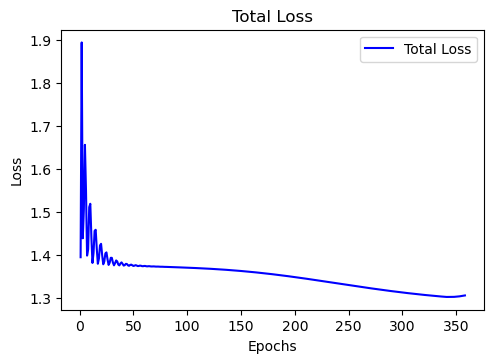

In [13]:
import csv

physics_hyperparam = [0.0005]
epochs = [400]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )
results={}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
        for physics_weight in physics_hyperparam:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCNModel_Hybrid()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 41])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback_Hybrid(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=20,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[early_stopping,loss_tracker])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 41])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
            result_temp = {
                'name':'TΔS with Multi-Loss',
                'y_test': y_test,
                'test_loss': eval,
                'y_pred_test': y_pred_test,
                'MAD': y_difference,
                'all_losses': loss_tracker.total_losses,
                'empirical_losses': loss_tracker.empirical_losses if hasattr(loss_tracker, 'empirical_losses') else None,
                'physical_losses': loss_tracker.physical_losses if hasattr(loss_tracker, 'physical_losses') else None,
                'hyperparameters': {
                                    'physics_weight': physics_weight,
                                    'epochs': epoch,
                                    'initial_learning_rate': 0.005,
                                    'decay_steps': 10000,
                                    'decay_rate': 0.9
                }
            }

            
            # Also append to the all_results list for combined saving later
            results["multi_loss_run"] = result_temp
            all_results.append(result_temp)
            
        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
 

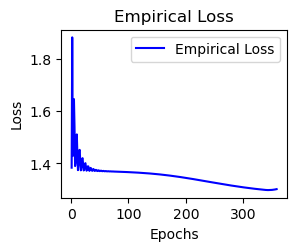

In [14]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [15]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

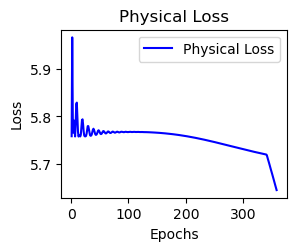

In [16]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

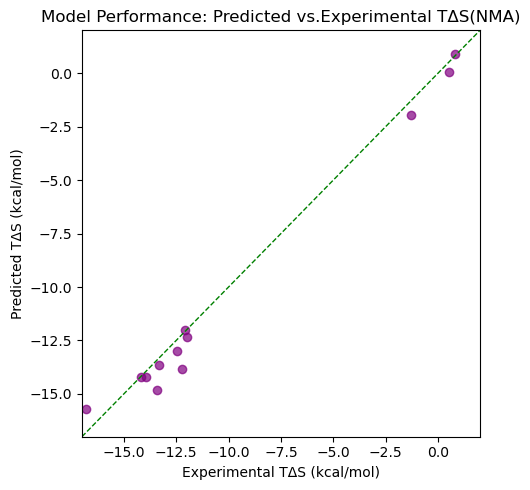

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Model Performance: Predicted vs.Experimental TΔS(NMA)")
plt.scatter(hybrid_y_true, hybrid_y_pred, alpha=0.7, color="purple")
plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-17, 2)
plt.ylim(-17, 2)


# Reference y = x line
plt.plot([-17, 2], [-17, 2], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Graphs/Model_Performance_Predicted_vs_Experimental_NMA_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

## NMA ENTROPY WITHOUT LOSS

In [18]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['complex_name'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [19]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['complex_name'] == pdb]['DELTA_S'].to_numpy()[0])

In [20]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
len(X_train), len(X_test), len(y_train), len(y_test)

(52, 13, 52, 13)

In [22]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, -1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
mn.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
mn.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_nohyb = np.array(X_train)
y_train_nohyb = np.array(y_train)

loss_tracker_nohyb = LossComponentsCallback(mn)

early_stop = EarlyStopping(
monitor='loss',           
patience=20,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = mn.fit(X_train_nohyb, y_train_nohyb, epochs = 100, batch_size=len(X_train_nohyb), callbacks=[early_stop,loss_tracker_nohyb])

Epoch 1/100
1/1 [==============================] - 50s 50s/step - loss: 1.3839
Epoch 2/100
1/1 [==============================] - 1s 607ms/step - loss: 1.8885
Epoch 3/100
1/1 [==============================] - 0s 482ms/step - loss: 1.4293
Epoch 4/100
1/1 [==============================] - 1s 504ms/step - loss: 1.4964
Epoch 5/100
1/1 [==============================] - 0s 463ms/step - loss: 1.6493
Epoch 6/100
1/1 [==============================] - 1s 648ms/step - loss: 1.5416
Epoch 7/100
1/1 [==============================] - 1s 666ms/step - loss: 1.3902
Epoch 8/100
1/1 [==============================] - 1s 672ms/step - loss: 1.4053
Epoch 9/100
1/1 [==============================] - 1s 645ms/step - loss: 1.5043
Epoch 10/100
1/1 [==============================] - 1s 664ms/step - loss: 1.5126
Epoch 11/100
1/1 [==============================] - 1s 687ms/step - loss: 1.4351
Epoch 12/100
1/1 [==============================] - 1s 652ms/step - loss: 1.3743
Epoch 13/100
1/1 [====================

In [23]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 41])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = mn.evaluate(X_test_nohyb, y_test_nohyb)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))

result_temp = {
    'name':'TΔS with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)



1/1 [==============================] - 4s 4s/step - loss: 2.0368
The mean absolute difference between y_tru & y_pred is : 5.801554951122386


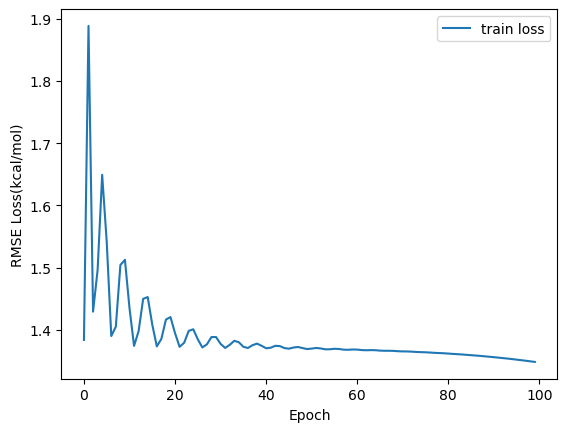

In [24]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE Loss(kcal/mol)')
plt.legend()
plt.show()

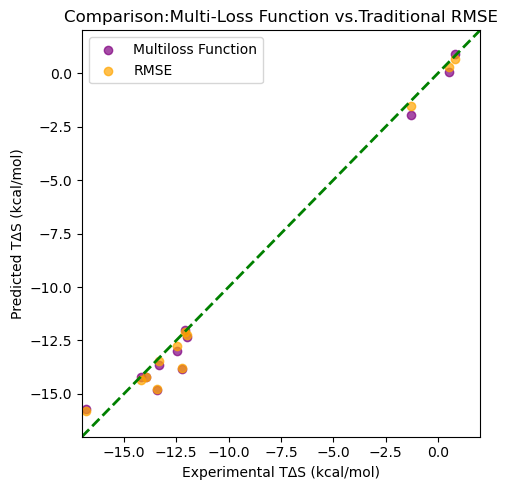

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Comparison:Multi-Loss Function vs.Traditional RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-17,2)
plt.ylim(-17,2)

# Reference y = x line
plt.plot([-17, 2], [-17, 2], color='green', lw=2, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('NMAEntropy_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## NMA Entropy with Structural

In [26]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['complex_name'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [27]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['complex_name'] == pdb]['DELTA_S'].to_numpy()[0])

In [28]:
len(X_train), len(X_test), len(y_train), len(y_test)

(52, 13, 52, 13)

In [29]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, -1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
       
class LossComponentsCallback_Struct(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms= PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
ms.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
ms.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 41])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_struct = np.array(X_train)
y_train_struct = np.array(y_train)

loss_tracker_struct = LossComponentsCallback_Struct(ms)

early_stop = EarlyStopping(
monitor='loss',           
patience=15,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = ms.fit(X_train_struct, y_train_struct, epochs = 200, batch_size=len(X_train_struct), callbacks=[early_stop,loss_tracker_struct])

Epoch 1/200
Inside call
Inside call
1/1 [==============================] - 56s 56s/step - loss: 1.3915
Epoch 2/200
1/1 [==============================] - 10s 10s/step - loss: 1.8907
Epoch 3/200
1/1 [==============================] - 10s 10s/step - loss: 1.4355
Epoch 4/200
1/1 [==============================] - 10s 10s/step - loss: 1.5015
Epoch 5/200
1/1 [==============================] - 10s 10s/step - loss: 1.6527
Epoch 6/200
1/1 [==============================] - 10s 10s/step - loss: 1.5455
Epoch 7/200
1/1 [==============================] - 10s 10s/step - loss: 1.3952
Epoch 8/200
1/1 [==============================] - 10s 10s/step - loss: 1.4100
Epoch 9/200
1/1 [==============================] - 10s 10s/step - loss: 1.5078
Epoch 10/200
1/1 [==============================] - 10s 10s/step - loss: 1.5157
Epoch 11/200
1/1 [==============================] - 10s 10s/step - loss: 1.4386
Epoch 12/200
1/1 [==============================] - 10s 10s/step - loss: 1.3782
Epoch 13/200
1/1 [=======

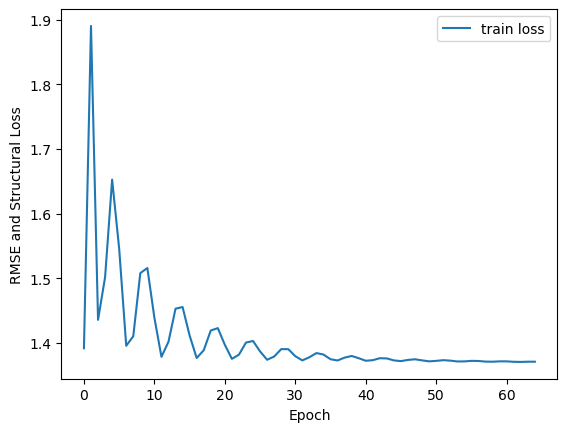

In [30]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [31]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 41])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
eval_struct = ms.evaluate(X_test_struct, y_test_struct)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'TΔS(NMA) with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)


Inside call
1/1 [==============================] - 5s 5s/step
Inside call
1/1 [==============================] - 7s 7s/step - loss: 1.9583
The mean absolute difference between y_tru & y_pred is : 5.7279910558068545


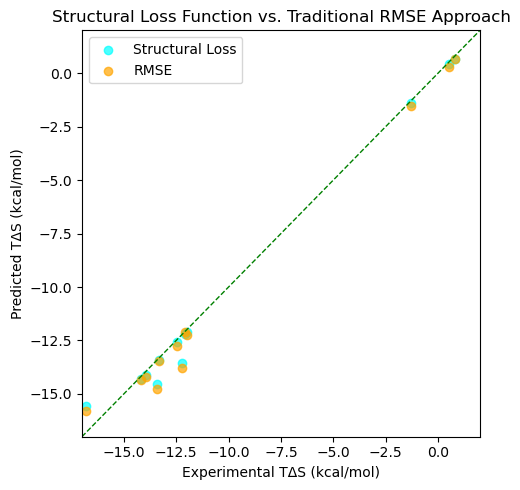

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")

plt.xlim(-17,2)
plt.ylim(-17, 2)

# Reference y = x line
plt.plot([-17, 2], [-17, 2], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_NMA_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

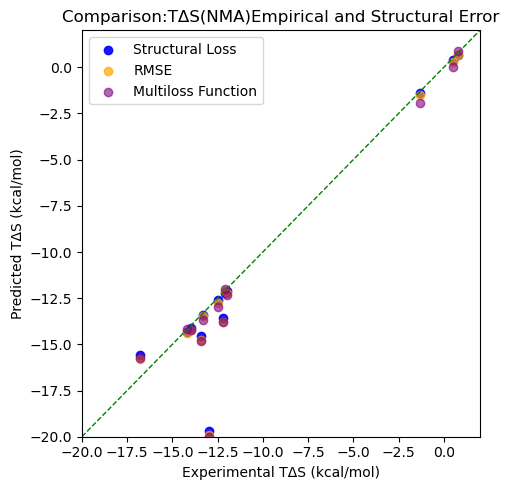

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Comparison:TΔS(NMA)Empirical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multiloss Function")

plt.xlabel("Experimental TΔS (kcal/mol)")
plt.ylabel("Predicted TΔS (kcal/mol)")
plt.xlim(-17, 2)
plt.ylim(-17, 2)

# Reference y = x line
plt.plot([-17, 2], [-17, 2], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Emp_Struct_Phy_Loss_NMA_TΔS.png',dpi=100, bbox_inches='tight')
plt.show()

In [34]:
# Save individual run results
individual_filename = f'/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/Result_Pickle/NMA_Entropy_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")

Results saved to /home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/Result_Pickle/NMA_Entropy_Predictions.pkl
